In [1]:
import pandas as pd
df = pd.read_csv("credit_risk_dataset.csv")

In [2]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_amnt                   32581 non-null  int64  
 6   loan_int_rate               29465 non-null  float64
 7   loan_status                 32581 non-null  int64  
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


In [4]:
# Impute loan_int_rate: Since it is an important feature, we can fill missing values with the median value:
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [5]:
# Drop person_emp_length: Since it has a low correlation, we can drop rows with missing values for this feature 
df.dropna(subset=['person_emp_length'], inplace=True)

In [6]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [7]:
# Step 1: Data Preparation
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)


In [8]:
df_encoded.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,True,False,False,False,True,False,True
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,False,True,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,False,False,False,True,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,True,False,False,True,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,True,False,False,True,False,False,True


In [9]:
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Step 2: Perform Statistical Tests
# 1. T-Test: Compare mean loan_int_rate between loan_status groups
loan_int_rate_default = df[df['loan_status'] == 1]['loan_int_rate']
loan_int_rate_non_default = df[df['loan_status'] == 0]['loan_int_rate']
t_stat, p_val_ttest = stats.ttest_ind(loan_int_rate_default, loan_int_rate_non_default)
print(f"T-Test: t-statistic = {t_stat}, p-value = {p_val_ttest}")

T-Test: t-statistic = 60.81109868574247, p-value = 0.0


In [10]:
print(df[df['loan_status'] == 1]['loan_int_rate'].mean())
print(df[df['loan_status'] == 0]['loan_int_rate'].mean())

12.92921037210665
10.514981094127112


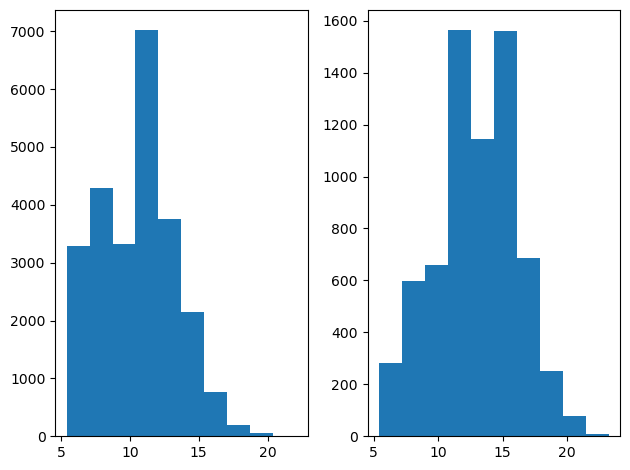

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(1, 2, 1)
plt.hist(df[df['loan_status'] == 0]['loan_int_rate'],bins=10)
plt.subplot(1, 2, 2)
plt.hist(df[df['loan_status'] == 1]['loan_int_rate'],bins=10)
plt.tight_layout()
plt.show()

In [ ]:
# People who have taken loan at higher interest rate tends to default more

In [12]:
# 2. Chi-Square Test of Independence: Test independence between person_home_ownership and loan_status
chi2_stat, p_val_chi, dof, expected = stats.chi2_contingency(pd.crosstab(df['person_home_ownership'], df['loan_status']))
print(f"Chi-Square Test: chi2-statistic = {chi2_stat}, p-value = {p_val_chi}")


Chi-Square Test: chi2-statistic = 1815.1965185398378, p-value = 0.0


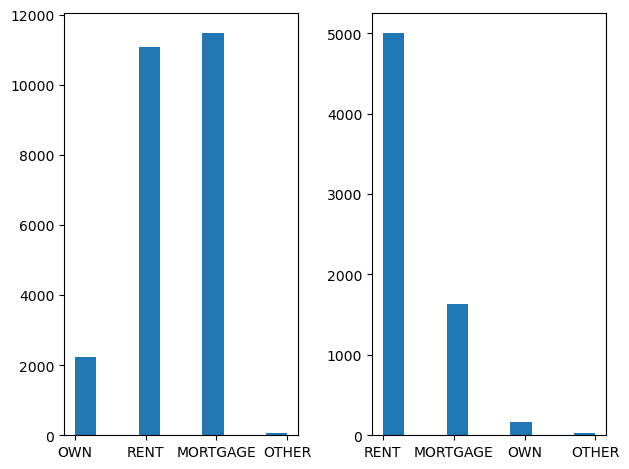

In [13]:
plt.subplot(1, 2, 1)
plt.hist(df[df['loan_status'] == 0]['person_home_ownership'])
plt.subplot(1, 2, 2)
plt.hist(df[df['loan_status'] == 1]['person_home_ownership'])
plt.tight_layout()
plt.show()

In [ ]:
# People with home ownership as Rent are more likely to default, ratio wise people with mortgage as a home ownership are less risky

In [14]:
# 3. ANOVA: Compare loan_amnt across loan_intent groups
f_stat, p_val_anova = stats.f_oneway(*[df[df['loan_intent'] == intent]['loan_amnt'] for intent in df['loan_intent'].unique()])
print(f"ANOVA: F-statistic = {f_stat}, p-value = {p_val_anova}")

ANOVA: F-statistic = 14.321595894633255, p-value = 4.9201325192021716e-14


In [130]:
# Group by 'loan_intent' and calculate the total 'loan_amnt' for each category
total_loan_amnt = df.groupby('loan_intent')['loan_amnt'].sum()

# Calculate the total loan amount across all categories
total = df['loan_amnt'].sum()

# Filter the result for the specific categories you're interested in and calculate the percentage
categories = ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
result = (total_loan_amnt.loc[categories] / total) * 100

# Display the result
print(result.sort_values(ascending=False))


loan_intent
EDUCATION            19.565264
MEDICAL              18.013525
VENTURE              17.524777
PERSONAL             16.920154
DEBTCONSOLIDATION    15.995471
HOMEIMPROVEMENT      11.980809
Name: loan_amnt, dtype: float64


In [136]:
# Filter the DataFrame for loans where 'loan_status' is 1 (defaulted loans)
df_defaulted = df[df['loan_status'] == 1]

# Group by 'loan_intent' and calculate the total 'loan_amnt' for each category among defaulted loans
total_loan_amnt = df_defaulted.groupby('loan_intent')['loan_amnt'].sum()

# Calculate the total loan amount across all categories where 'loan_status' is 1
total = df_defaulted['loan_amnt'].sum()

# Filter the result for the specific categories you're interested in and calculate the percentage
categories = ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
default_result = (total_loan_amnt.loc[categories] / total) * 100

# Display the result sorted in descending order
print(default_result.sort_values(ascending=False))


loan_intent
MEDICAL              23.659275
DEBTCONSOLIDATION    21.560253
EDUCATION            15.718719
PERSONAL             14.866647
VENTURE              12.209226
HOMEIMPROVEMENT      11.985880
Name: loan_amnt, dtype: float64


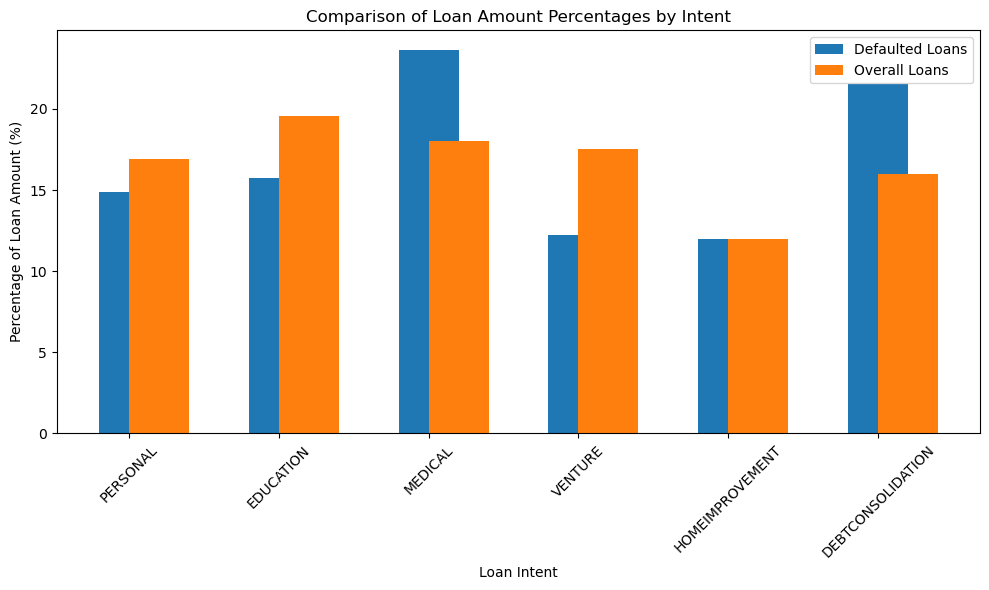

In [132]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.bar(default_result.index, default_result, width=0.4, label='Defaulted Loans', align='center')
ax.bar(result.index, result, width=0.4, label='Overall Loans', align='edge')

# Add labels and title
ax.set_xlabel('Loan Intent')
ax.set_ylabel('Percentage of Loan Amount (%)')
ax.set_title('Comparison of Loan Amount Percentages by Intent')
ax.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Debt Consolidation and Medical have a higher contribution to defaults compared to their overall loan distribution, while Personal, Education, and Venture have a lower contribution to defaults compared to their overall loan distribution.

In [128]:
# Filter the DataFrame for loans where 'loan_status' is 1 (defaulted loans)
df_defaulted = df[df['loan_status'] == 1]

# Group by 'loan_intent' and calculate the total 'loan_amnt' for each category among defaulted loans
total_loan_amnt = df_defaulted.groupby('loan_intent')['loan_amnt'].sum()

# Calculate the total loan amount across all categories where 'loan_status' is 1
total = df_defaulted['loan_amnt'].sum()

# Filter the result for the specific categories you're interested in and calculate the percentage
categories = ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
default_result = (total_loan_amnt.loc[categories] / total) * 100

# Display the result sorted in descending order
print(default_result.sort_values(ascending=False))


loan_intent
MEDICAL              23.659275
DEBTCONSOLIDATION    21.560253
EDUCATION            15.718719
PERSONAL             14.866647
VENTURE              12.209226
HOMEIMPROVEMENT      11.985880
Name: loan_amnt, dtype: float64


In [100]:
# 4. Pearson Correlation: Between person_age and cb_person_cred_hist_length
pearson_corr, p_val_pearson = stats.pearsonr(df['person_age'], df['cb_person_cred_hist_length'])
print(f"Pearson Correlation: correlation = {pearson_corr}, p-value = {p_val_pearson}")

Pearson Correlation: correlation = 0.8588285310064729, p-value = 0.0


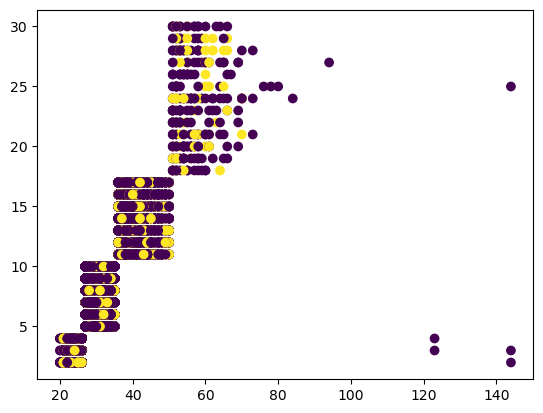

In [16]:
plt.scatter(x=df['person_age'],y=df['cb_person_cred_hist_length'],c=df["loan_status"])

In [17]:
from scipy.stats import mannwhitneyu, kruskal, spearmanr, wilcoxon

# 6. Mann-Whitney U Test: Compare employment length (person_emp_length) between defaulters and non-defaulters.
emp_length_defaulted = df.loc[df['loan_status'] == 1, 'person_emp_length'][df['person_emp_length'] < df['person_emp_length'].quantile(0.99)]
emp_length_non_defaulted = df.loc[df['loan_status'] == 0, 'person_emp_length'][df['person_emp_length'] < df['person_emp_length'].quantile(0.99)]
mannwhitneyu_test = mannwhitneyu(emp_length_defaulted, emp_length_non_defaulted)

print(f"Mann-Whitney U Test Statistic: {mannwhitneyu_test.statistic}, p-value: {mannwhitneyu_test.pvalue}")

Mann-Whitney U Test Statistic: 71838066.5, p-value: 1.713942685378898e-67


In [18]:
print(df[df['loan_status'] == 0]['person_emp_length'].mean())
print(df[df['loan_status'] == 1]['person_emp_length'].mean())

4.968744971842317
4.137562261939642


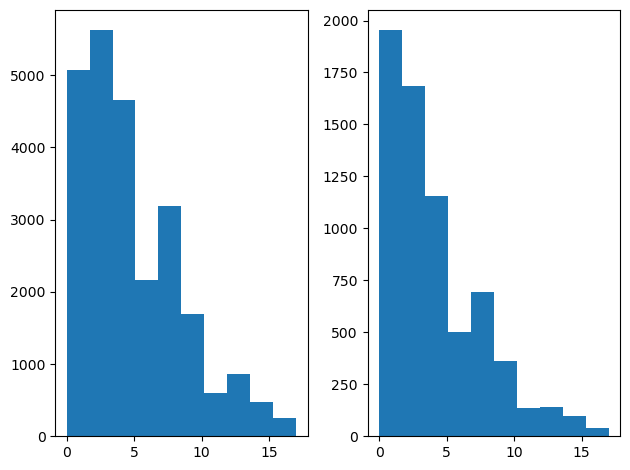

In [19]:
plt.subplot(1, 2, 1)
plt.hist(df.loc[df['loan_status'] == 0, 'person_emp_length'][df['person_emp_length'] < df['person_emp_length'].quantile(0.99)],bins=10)
plt.subplot(1, 2, 2)
plt.hist(df.loc[df['loan_status'] == 1, 'person_emp_length'][df['person_emp_length'] < df['person_emp_length'].quantile(0.99)],bins=10)
plt.tight_layout()
plt.show()

In [83]:
below_03 = df.loc[(df['loan_status'] == 0) & (df["person_emp_length"] <= 6)].shape[0]
above_03 = df.loc[(df['loan_status'] == 0) & (df["person_emp_length"] > 6)].shape[0]
total = df[df['loan_status'] == 0].shape[0]
print(f"Percentage of non-default below 6 emp_length={(below_03/total)} \nPercentage of non-default above 6 emp_length={(above_03/total)}")


Percentage of non-default below 6 emp_length=0.704625905068383 
Percentage of non-default above 6 emp_length=0.29537409493161704


People with low emp_length tends to have higher default

In [20]:
# # 7. Kruskal-Wallis Test: Compare loan_percent_income across different loan intents.

# Create the groups based on available encoded columns
loan_intent_groups = [df_encoded['loan_percent_income'][df_encoded['loan_intent_' + intent] == 1] for intent in ['EDUCATION', 'MEDICAL', 'HOMEIMPROVEMENT','PERSONAL','VENTURE']]

# Perform the Kruskal-Wallis Test
kruskal_test = kruskal(*loan_intent_groups)

# Print the result
print(f"Kruskal-Wallis Test Statistic: {kruskal_test.statistic}, p-value: {kruskal_test.pvalue}")

Kruskal-Wallis Test Statistic: 14.934374817968475, p-value: 0.0048392814959621056


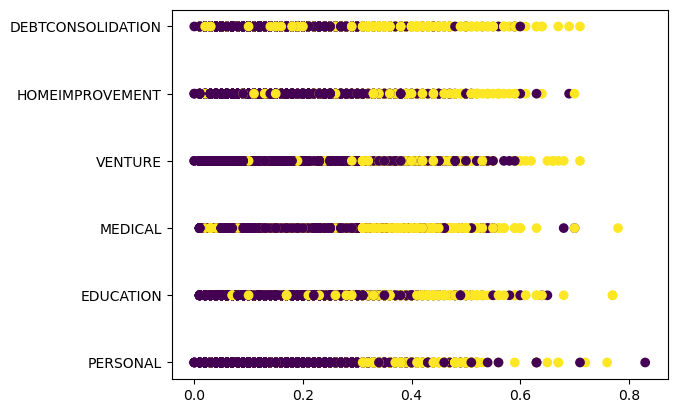

In [21]:
plt.scatter(x=df['loan_percent_income'],y=df['loan_intent'],c=df["loan_status"])

In [85]:
below_03 = df.loc[(df['loan_status'] == 0) & (df["loan_percent_income"] < 0.3)].shape[0]
above_03 = df.loc[(df['loan_status'] == 0) & (df["loan_percent_income"] > 0.3)].shape[0]
total = df[df['loan_status'] == 0].shape[0]
print(f"Percentage of non-default below 0.3 loan_percent_income={(below_03/total)} \nPercentage of non-default above 0.3 loan_percent_income={(above_03/total)}")


Percentage of non-default below 0.3 loan_percent_income=0.9430812550281577 
Percentage of non-default above 0.3 loan_percent_income=0.04344328238133548


Most of the non-defaulters tend to have loan_percent_income below 0.3